<a href="https://colab.research.google.com/github/codedmachine111/ML/blob/master/Deep%20Learning/MNIST_WGAN_GP(Transformer%20generator).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.layers import (Input, Conv2D, ReLU, BatchNormalization, Add, AveragePooling2D, Flatten, Dense, LeakyReLU, Conv2DTranspose, Dropout)
from keras.initializers import RandomNormal
from keras.constraints import Constraint
from keras import backend

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras import layers
from tensorflow import Tensor

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython import display
from tqdm.auto import trange

In [ ]:
def plot_results(images, n_cols=None, title=None):

    n_cols = n_cols or len(images)
    n_rows = (len(images) - 1) // n_cols + 1

    if images.shape[-1] == 1:
        images = np.squeeze(images, axis=-1)

    fig = plt.figure(figsize=(n_cols, n_rows))

    for index, image in enumerate(images):
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(image, cmap="binary")
        plt.axis("off")

    plt.suptitle(title)

In [ ]:
BATCH_SIZE = 128
CODINGS_SIZE = 100
N_EPOCHS = 100
D_STEPS = 5
GP_WEIGHT = 10.0

In [ ]:
def prepare_data(label, batch_size):
    (X_train, y_train), (X_test, y_test) = keras.datasets.mnist.load_data()
    X_all = np.concatenate([X_train, X_test])
    y_all = np.concatenate([y_train, y_test])

    X_all = X_all.astype(np.float32) / 255
    X_all = X_all.reshape(-1, 28, 28, 1) * 2. - 1.
    X_train = X_all[np.where(y_all == label)]

    dataset = tf.data.Dataset.from_tensor_slices(X_train)
    dataset = dataset.shuffle(1024)
    dataset = dataset.batch(BATCH_SIZE, drop_remainder=True).prefetch(1)

    return dataset

In [ ]:
def prepare_images(label):
    (X_train, y_train), (X_test, y_test) = keras.datasets.mnist.load_data()
    X_all = np.concatenate([X_train, X_test])
    y_all = np.concatenate([y_train, y_test])

    X_all = X_all.astype(np.float32) / 255
    X_all = X_all.reshape(-1, 28, 28, 1) * 2. - 1.
    X_train = X_all[np.where(y_all == label)]

    return X_train

## Generator model

In [ ]:
def downsample(filters, size, apply_batchnorm=True):
    initializer = tf.random_normal_initializer(0., 0.02)

    result = tf.keras.Sequential()
    result.add(
      tf.keras.layers.Conv2D(filters, size, strides=2, padding='same',
                             kernel_initializer=initializer, use_bias=False))

    if apply_batchnorm:
        result.add(tf.keras.layers.BatchNormalization())

    result.add(tf.keras.layers.LeakyReLU())

    return result

In [ ]:
def relu_bn(inputs: Tensor) -> Tensor:
    relu = ReLU()(inputs)
    bn = BatchNormalization()(relu)
    return bn

In [ ]:
def residual_block(x: Tensor, downsample: bool, filters: int, kernel_size: int = 3) -> Tensor:
    y = Conv2D(kernel_size=kernel_size,
               strides= (1 if not downsample else 2),
               filters=filters,
               padding="same")(x)
    y = relu_bn(y)
    y = Conv2D(kernel_size=kernel_size,
               strides=1,
               filters=filters,
               padding="same")(y)

    if downsample:
        x = Conv2D(kernel_size=1,
                   strides=2,
                   filters=filters,
                   padding="same")(x)
    out = Add()([x, y])
    out = relu_bn(out)
    return out

In [ ]:
class TransformerBlock(tf.keras.layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super(TransformerBlock, self).__init__()
        self.att = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = tf.keras.Sequential(
            [layers.Dense(ff_dim, activation="relu"), layers.Dense(embed_dim),]
        )
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(rate)
        self.dropout2 = layers.Dropout(rate)

    def call(self, inputs, training):
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)

In [ ]:
def Generator_MNIST(noise_dim,
                    projection_dim,
                    num_heads,
                    ff_dim):
    # Input layer
    noise_input = layers.Input(shape=(noise_dim,))

    # Dense layer to map noise to an intermediate shape
    x = layers.Dense(14 * 14 * 64)(noise_input)
    x = layers.Reshape((14, 14, 64))(x)
    x = layers.BatchNormalization()(x)

    # Transformer blocks for capturing spatial dependencies in the noise
    x = TransformerBlock(64, num_heads, ff_dim)(x)
    x = TransformerBlock(64, num_heads, ff_dim)(x)

    # Upsampling block
    # x = layers.Conv2DTranspose(32, (4, 4), strides=(2, 2), padding='same', use_bias=False)(x)
    # x = layers.BatchNormalization()(x)
    # x = layers.LeakyReLU()(x)
    # x = residual_block(x, downsample=False, filters=32)

    skip = keras.layers.Conv2DTranspose(64, kernel_size=3, strides=1, padding="SAME", activation="selu")(x)
    skip = keras.layers.BatchNormalization()(skip)
    skip = keras.layers.Conv2DTranspose(64, kernel_size=3, strides=1, padding="SAME", activation="selu")(skip)
    skip = keras.layers.BatchNormalization()(skip)
    outputs = keras.layers.Conv2DTranspose(1, kernel_size=3, strides=2, padding="SAME",activation="tanh")(x)

    # converting to 1 channel
    # x = layers.Conv2D(1, (7, 7), strides=(1, 1), padding='same', use_bias=False, activation='tanh')(x)

    return tf.keras.Model(inputs=noise_input, outputs=outputs, name='generator')

In [ ]:
gen_projection_dim = 64
gen_num_heads = 4
gen_ff_dim = 4
noise_dim=100

In [ ]:
generator_m = Generator_MNIST(noise_dim, gen_projection_dim, gen_num_heads, gen_ff_dim)
generator_m.summary()

Model: "generator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 100)]             0         
                                                                 
 dense (Dense)               (None, 12544)             1266944   
                                                                 
 reshape (Reshape)           (None, 14, 14, 64)        0         
                                                                 
 batch_normalization (Batch  (None, 14, 14, 64)        256       
 Normalization)                                                  
                                                                 
 transformer_block (Transfo  (None, 14, 14, 64)        67204     
 rmerBlock)                                                      
                                                                 
 transformer_block_1 (Trans  (None, 14, 14, 64)        67

## Discriminator

In [ ]:
def build_discriminator():
    return keras.models.Sequential([
    keras.layers.Conv2D(64, kernel_size=3, strides=1, padding="SAME", activation=keras.layers.LeakyReLU(0.2), input_shape=[28, 28, 1]),
    keras.layers.Conv2D(128, kernel_size=3, strides=1, padding="SAME", activation=keras.layers.LeakyReLU(0.2)),
    keras.layers.Conv2D(128, kernel_size=3, strides=2, padding="SAME", activation=keras.layers.LeakyReLU(0.2)),
    keras.layers.Dropout(0.4),
    keras.layers.Conv2D(128, kernel_size=3, strides=1, padding="SAME", activation=keras.layers.LeakyReLU(0.2)),
    keras.layers.Conv2D(128, kernel_size=3, strides=1, padding="SAME", activation=keras.layers.LeakyReLU(0.2)),
    keras.layers.Conv2D(128, kernel_size=3, strides=2, padding="SAME", activation=keras.layers.LeakyReLU(0.2)),
    keras.layers.Dropout(0.4),
    keras.layers.Flatten(),
    keras.layers.Dense(1)
], name='discriminator')

In [ ]:
class WGAN(keras.Model):
    def __init__(
        self,
        discriminator,
        generator,
        latent_dim,
        discriminator_extra_steps=5,
        gp_weight=10.0,
    ):
        super().__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim
        self.d_steps = discriminator_extra_steps
        self.gp_weight = gp_weight

    def compile(self, d_optimizer, g_optimizer, d_loss_fn, g_loss_fn):
        super().compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.d_loss_fn = d_loss_fn
        self.g_loss_fn = g_loss_fn

    def gradient_penalty(self, batch_size, real_images, fake_images):
        """ Calculates the gradient penalty.

        This loss is calculated on an interpolated image
        and added to the discriminator loss.
        """
        # Get the interpolated image
        alpha = tf.random.normal([batch_size, 1, 1, 1], 0.0, 1.0)
        diff = fake_images - real_images
        interpolated = real_images + alpha * diff

        with tf.GradientTape() as gp_tape:
            gp_tape.watch(interpolated)
            # 1. Get the discriminator output for this interpolated image.
            pred = self.discriminator(interpolated, training=True)

        # 2. Calculate the gradients w.r.t to this interpolated image.
        grads = gp_tape.gradient(pred, [interpolated])[0]
        # 3. Calculate the norm of the gradients.
        norm = tf.sqrt(tf.reduce_sum(tf.square(grads), axis=[1, 2, 3]))
        gp = tf.reduce_mean((norm - 1.0) ** 2)
        return gp

    def train_step(self, real_images):
        if isinstance(real_images, tuple):
            real_images = real_images[0]

        batch_size = tf.shape(real_images)[0]

        # For each batch, we are going to perform the
        # following steps:
        # 1. Train the generator and get the generator loss
        # 2. Train the discriminator and get the discriminator loss
        # 3. Calculate the gradient penalty
        # 4. Multiply this gradient penalty with a constant weight factor
        # 5. Add the gradient penalty to the discriminator loss
        # 6. Return the generator and discriminator losses as a loss dictionary

        # Train the discriminator for `x` more steps (typically 5) as compared to
        # one step of the generator.
        for i in range(self.d_steps):
            random_latent_vectors = tf.random.normal(
                shape=(batch_size, self.latent_dim)
            )
            with tf.GradientTape() as tape:
                fake_images = self.generator(random_latent_vectors, training=True)
                fake_logits = self.discriminator(fake_images, training=True)
                real_logits = self.discriminator(real_images, training=True)

                d_cost = self.d_loss_fn(real_img=real_logits, fake_img=fake_logits)
                gp = self.gradient_penalty(batch_size, real_images, fake_images)
                d_loss = d_cost + gp * self.gp_weight

            d_gradient = tape.gradient(d_loss, self.discriminator.trainable_variables)
            self.d_optimizer.apply_gradients(
                zip(d_gradient, self.discriminator.trainable_variables)
            )

        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))
        with tf.GradientTape() as tape:
            generated_images = self.generator(random_latent_vectors, training=True)
            gen_img_logits = self.discriminator(generated_images, training=True)
            g_loss = self.g_loss_fn(gen_img_logits)

        gen_gradient = tape.gradient(g_loss, self.generator.trainable_variables)
        self.g_optimizer.apply_gradients(
            zip(gen_gradient, self.generator.trainable_variables)
        )
        return {"d_loss": d_loss, "g_loss": g_loss}

def discriminator_loss(real_img, fake_img):
    real_loss = tf.reduce_mean(real_img)
    fake_loss = tf.reduce_mean(fake_img)
    return fake_loss - real_loss


def generator_loss(fake_img):
    return -tf.reduce_mean(fake_img)

In [ ]:
discriminator = build_discriminator()
discriminator.summary()

Model: "discriminator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 64)        640       
                                                                 
 conv2d_1 (Conv2D)           (None, 28, 28, 128)       73856     
                                                                 
 conv2d_2 (Conv2D)           (None, 14, 14, 128)       147584    
                                                                 
 dropout_4 (Dropout)         (None, 14, 14, 128)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 14, 14, 128)       147584    
                                                                 
 conv2d_4 (Conv2D)           (None, 14, 14, 128)       147584    
                                                                 
 conv2d_5 (Conv2D)           (None, 7, 7, 128)       

## GAN Model

11490434/11490434 [==============================] - 0s 0us/step
Epoch 1/100
53/53 [==============================] - 85s 1s/step - d_loss: -26.1079 - g_loss: -5.5622
Epoch 2/100
53/53 [==============================] - 54s 1s/step - d_loss: -17.4066 - g_loss: -5.1563
Epoch 3/100
53/53 [==============================] - 54s 1s/step - d_loss: -8.8032 - g_loss: 1.6603
Epoch 4/100
53/53 [==============================] - 54s 1s/step - d_loss: -4.3446 - g_loss: 4.1546
Epoch 5/100
53/53 [==============================] - 54s 1s/step - d_loss: -3.2467 - g_loss: 10.5600
Epoch 6/100
53/53 [==============================] - 54s 1s/step - d_loss: -2.6780 - g_loss: 10.1671
Epoch 7/100
53/53 [==============================] - 55s 1s/step - d_loss: -2.8439 - g_loss: 11.1916
Epoch 8/100
53/53 [==============================] - 54s 1s/step - d_loss: -2.7861 - g_loss: 10.9148
Epoch 9/100
53/53 [==============================] - 55s 1s/step - d_loss: -2.9943 - g_loss: 7.5217
Epoch 10/100
53/53 [=======

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 1/100
20/61 [========>.....................] - ETA: 42s - d_loss: -15.9807 - g_loss: 12.7173

KeyboardInterrupt: ignored

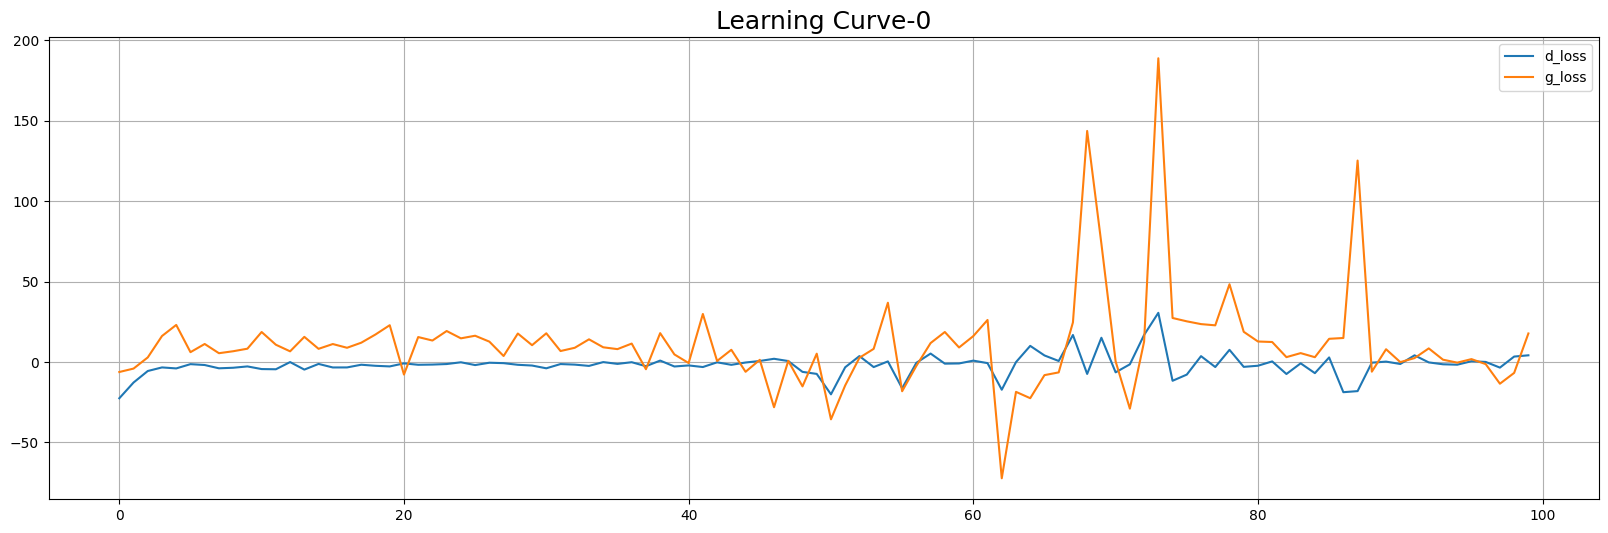

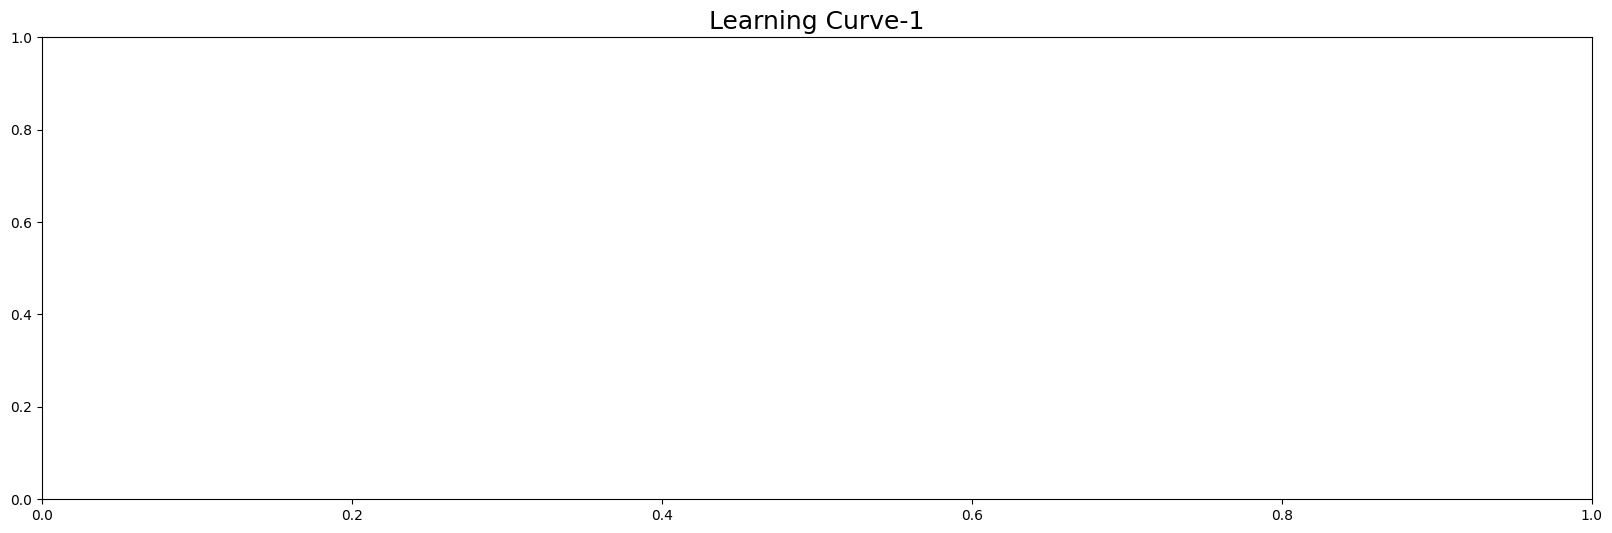

In [ ]:
for i in range(10):
    LABEL = i
    dataset = prepare_data(LABEL, BATCH_SIZE)

    generator = generator_m
    discriminator = build_discriminator()

    gan = WGAN(
        discriminator=discriminator, generator=generator,
        latent_dim=CODINGS_SIZE, discriminator_extra_steps=D_STEPS, gp_weight=GP_WEIGHT
    )
    gan.compile(
        d_optimizer=keras.optimizers.Adam(learning_rate=0.0001),
        g_optimizer=keras.optimizers.Adam(learning_rate=0.0001),
        g_loss_fn=generator_loss,
        d_loss_fn=discriminator_loss,
    )

    fig, ax = plt.subplots(figsize=(20, 6))
    ax.set_title(f'Learning Curve-{LABEL}', fontsize=18)
    history = gan.fit(dataset, epochs=N_EPOCHS, verbose=1)
    pd.DataFrame(history.history).plot(ax=ax)
    ax.grid()

    generator.save(f'MNIST-AUG-WGAN-{LABEL}.h5')

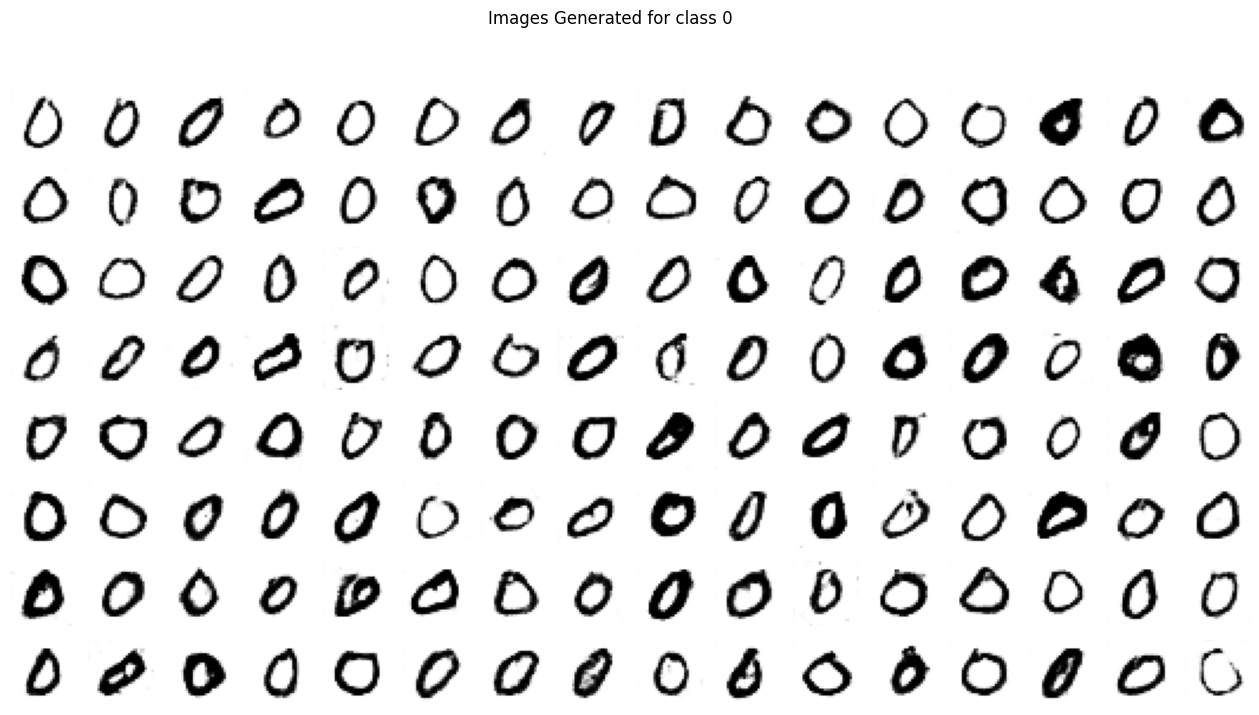

In [ ]:
from scipy.linalg import sqrtm

def frechet_distance(act1, act2):
    mu1, sigma1 = np.mean(act1, axis=0), np.cov(act1, rowvar=False)
    mu2, sigma2 = np.mean(act2, axis=0), np.cov(act2, rowvar=False)
    ssdiff = np.sum((mu1 - mu2)**2.0)
    covmean = sqrtm(sigma1.dot(sigma2))
    if np.iscomplexobj(covmean):
        covmean = covmean.real
    fid = ssdiff + np.trace(sigma1 + sigma2 - 2.0 * covmean)
    return fid


generator = keras.models.load_model('/content/MNIST-AUG-WGAN-0.h5', custom_objects={'TransformerBlock': TransformerBlock})
fake_images = generator(tf.random.normal([128, CODINGS_SIZE]))
plot_results(fake_images, 16, f'Images Generated for class 0')
plt.show()